In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.display import display, Markdown, Image

In [2]:
%matplotlib inline

In [3]:
!export FONTCONFIG_PATH=/etc/fonts

In [4]:
REPO_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
TASK_PATH = os.path.join(REPO_PATH, "tasks", "12-nlg", "12-nlg.md")
DATA_PATH = os.path.join(REPO_PATH, "tasks", "12-nlg", "opusparcus_v2.zip")

In [5]:
def show_markdown(path):
    with open(path, 'r') as fh:
        content = fh.read()
    display(Markdown(content))

In [6]:
show_markdown(TASK_PATH)

# Генерація перефразувань

## Завдання

Ваше завдання цього тижня - розробити seq2seq модель для генерації перефразувань на рівні символів, слів чи bpe. Ось корисні посилання:
- <https://keras.io/examples/lstm_seq2seq/>
- <https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html>
- <https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/>

Для тренування використайте [скорочений варіант корпусу Opusparcus](opusparcus_v2.zip). Врахуйте, що кожну пару перефразувань можна використовувати для тренування в обидва боки.

**Для довідки.** Оригінальний корпус [Opusparcus](https://korp.csc.fi/download/opusparcus/). Це корпус перефразувань, побудований на основі різних субтитрів до тих самих фільмів. Тренувальна вибірка у корпусі дуже велика (40 млн прикладів для англійської мови), але автоматично проанотована. Більшість перефразувань надто примітивні, тож скорочений варіант корпусу містить перші сто тисяч прикладів з високою відстанню редагування (значення останньої колонки; див. README).

## Метрики

Для оцінки якості генерації перефразувань використаймо дві метрики:
1. ROUGE-L, виміряна на dev-частині корпусу. Міряйте якість лише на прикладах з оцінкою 3.0–4.0 (див. останню колонку). Можна скористатися готовою імплементацією метрики з бібліотеки [py-rouge](https://pypi.org/project/py-rouge/).
2. Ручна оцінка якості. Виберіть 50 випадкових речень із dev-частини корпусу, згенеруйте перефразування для них та підготуйте Google-таблицю. Інший студент у групі оцінить якість генерації.

## Оцінювання

За побудову моделі - 80 балів. За анотування 50-ти прикладів генерації іншого студента - 20 балів.

Крайній термін: 30.05.2020


### Load the data

In [7]:
import zipfile
import time

import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm

In [8]:
def preprocess_sentence(x):
    x = x.strip().lower()
    if not x.startswith('<start>'):
        x = "<start> " + x
    if not x.endswith("<end>"):
        x = x + " <end>"
    return x

In [9]:
zf = zipfile.ZipFile(DATA_PATH) 

In [10]:
train = pd.read_csv(zf.open(os.path.join('opusparcus_v2', 'en-train-100K.txt')), sep='\t', header=None)
dev = pd.read_csv(zf.open(os.path.join('opusparcus_v2', 'en-dev.txt')), sep='\t', header=None)
test = pd.read_csv(zf.open(os.path.join('opusparcus_v2', 'en-test.txt')), sep='\t', header=None)

train.columns = ['pair_id', 'sent1', 'sent2', 'score1', 'score2', 'lang_num', 'distance']
dev.columns = ['pair_id', 'sent1', 'sent2', 'score2']
test.columns = ['pair_id', 'sent1', 'sent2', 'score2']

train['sent1'] = train['sent1'].map(preprocess_sentence)
train['sent2'] = train['sent2'].map(preprocess_sentence)

dev['sent1'] = dev['sent1'].map(preprocess_sentence)
dev['sent2'] = dev['sent2'].map(preprocess_sentence)

test['sent1'] = test['sent1'].map(preprocess_sentence)
test['sent2'] = test['sent2'].map(preprocess_sentence)

In [11]:
print(train.shape)
train.head()

(100000, 7)


,pair_id,sent1,sent2,score1,score2,lang_num,distance
0,en-N7,<start> jumby now wants to be born . <end>,<start> jumby want birth . <end>,77.5163,2.50000,5,9
1,en-N8,<start> it was a difficult and long delivery ....,<start> the delivery was difficult and long . ...,77.5163,2.50000,5,14
2,en-N12,<start> i like to be beautiful everyday . <end>,<start> i like to be pretty everyday . <end>,77.5163,2.50000,5,8
3,en-N22,<start> bernadette wants a prenup . <end>,<start> bernadette wants to get a prenup . <end>,77.5163,2.50000,5,7
4,en-N45,<start> don 't say you don 't remember me . <end>,<start> don 't tell me you don 't remember me ...,74.3904,3.33333,5,7


In [12]:
print(dev.shape)
dev.head()

(1455, 4)


,pair_id,sent1,sent2,score2
0,en-D69,<start> 300 heavy horse ? <end>,<start> we have no chance . <end>,1.5
1,en-D76,<start> when 'd you last see him ? <end>,<start> when was the last time you saw him ? <...,4.0
2,en-D119,<start> anyone who can verify that ? <end>,<start> can anyone corroborate that ? <end>,3.5
3,en-D168,<start> i 'm not promising anything . <end>,"<start> no promises , okay ? <end>",3.0
4,en-D242,<start> nothing 's changed . <end>,<start> things ain 't no different . <end>,3.5


In [13]:
print(test.shape)
test.head()

(1445, 4)


,pair_id,sent1,sent2,score2
0,en-T57,<start> i haven 't been contacted by anybody ....,<start> nobody 's contacted me . <end>,4.0
1,en-T115,<start> i see carnivores . <end>,<start> i think maybe you 're giving up too so...,1.0
2,en-T146,<start> did you just smoke ? <end>,<start> have you been smoking ? <end>,3.5
3,en-T166,"<start> look , i can be there in about four ho...",<start> your brother 's dead . <end>,1.0
4,en-T187,<start> i 'm pregnant . <end>,<start> i am with child . <end>,4.0


### Preprocess

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
tokenizer.fit_on_texts(np.concatenate([train.sent1.values, train.sent2.values]))

In [15]:
def text2tensor(x):
    tensor = tokenizer.texts_to_sequences(x)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor

In [16]:
# debug sample
# train_input = text2tensor(train.sent1.values[:1000])
# train_output = text2tensor(train.sent2.values[:1000])
# dev_input = text2tensor(dev.sent1.values[:100])
# dev_output = text2tensor(dev.sent2.values[:100])
# test_input = text2tensor(test.sent1.values[:100])
# test_output = text2tensor(test.sent2.values[:100])

train_input = text2tensor(train.sent1.values)
train_output = text2tensor(train.sent2.values)
dev_input = text2tensor(dev.sent1.values)
dev_output = text2tensor(dev.sent2.values)
test_input = text2tensor(test.sent1.values)
test_output = text2tensor(test.sent2.values)

In [17]:
def convert(tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, tokenizer.index_word[t]))

In [18]:
print("Input index to word mapping")
convert(train_input[0])
print("\nOuptut index to word mapping")
convert(train_output[0])

Input index to word mapping
2 ----> <start>
4613 ----> jumby
63 ----> now
691 ----> wants
11 ----> to
21 ----> be
1707 ----> born
4 ----> .
3 ----> <end>

Ouptut index to word mapping
2 ----> <start>
4613 ----> jumby
51 ----> want
3602 ----> birth
4 ----> .
3 ----> <end>


### Create a tf.data dataset

In [19]:
BUFFER_SIZE = train_input.shape[0]
BUFFER_SIZE_VAL = test_input.shape[0]
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
steps_per_epoch_val = BUFFER_SIZE_VAL // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_size = len(tokenizer.word_index) + 1

In [20]:
max_length_input, max_length_output = train_input.shape[1], train_output.shape[1]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_output)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [22]:
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_input, dev_output)).shuffle(BUFFER_SIZE)
dev_dataset = dev_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_output)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
example_input_batch, example_output_batch = next(iter(train_dataset))
example_input_batch.shape, example_output_batch.shape

(TensorShape([64, 47]), TensorShape([64, 39]))

### Create a tf model

#### Encoder/decoder

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [28]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 47, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 47, 1)


In [30]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 9743)


#### optimizer and the loss function

In [31]:
optimizer = tf.keras.optimizers.Adam()

In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### checkpoints

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Train the model

In [34]:
@tf.function
def train_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [35]:
@tf.function
def val_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    return batch_loss

In [36]:
n_epochs = 10
history = {}

for epoch in range(1, n_epochs+1):
    start_time = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0
    
    print(f"Epoch {epoch}/{n_epochs}")
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch)):
        batch_loss = val_step(inp, targ, enc_hidden)
        total_val_loss += batch_loss
    
    print('loss: {loss:.4f}\tval_loss: {val_loss:.4f}\texec_time: {exec_time:.2f} seconds\n'.format(
            loss = total_loss / steps_per_epoch, 
            val_loss = total_val_loss / steps_per_epoch_val,
            exec_time = time.time() - start_time))
    
    history['train'] = history.get('train', []) + [total_loss.numpy() / steps_per_epoch]
    history['val'] = history.get('val', []) + [total_val_loss.numpy() / steps_per_epoch_val]
            
#     saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1/10
loss: 0.4735	val_loss: 1.0913	exec_time: 409.24 seconds

Epoch 2/10
loss: 0.2754	val_loss: 1.0101	exec_time: 370.82 seconds

Epoch 3/10
loss: 0.2108	val_loss: 1.0352	exec_time: 371.14 seconds

Epoch 4/10
loss: 0.1725	val_loss: 1.0644	exec_time: 370.46 seconds

Epoch 5/10
loss: 0.1461	val_loss: 1.0816	exec_time: 370.86 seconds

Epoch 6/10
loss: 0.1274	val_loss: 1.1281	exec_time: 371.02 seconds

Epoch 7/10
loss: 0.1140	val_loss: 1.1719	exec_time: 371.73 seconds

Epoch 8/10
loss: 0.1038	val_loss: 1.2185	exec_time: 371.83 seconds

Epoch 9/10
loss: 0.0963	val_loss: 1.2358	exec_time: 372.04 seconds

Epoch 10/10
loss: 0.0907	val_loss: 1.2562	exec_time: 370.90 seconds



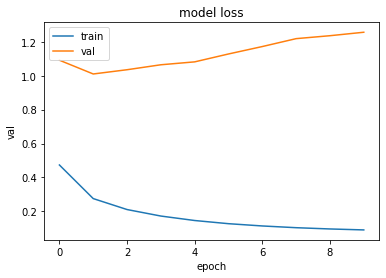

In [37]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Evaluate

In [39]:
import rouge

In [40]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_output, max_length_input))

    sentence = preprocess_sentence(sentence)
    inputs = tokenizer.texts_to_sequences([sentence])
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen=max_length_input,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in range(max_length_output):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer.index_word[predicted_id] + ' '

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [41]:
dev = dev.loc[dev.score2 >= 3.0]

In [43]:
dev['pred'] = dev['sent1'].map(lambda x: evaluate(x)[0].replace('<end>', '').strip())
dev['sent1'] = dev['sent1'].map(lambda x: x.replace('<start>', '').replace('<end>', '').strip())

In [60]:
dev[['sent1', 'pred']].sample(50)#.to_excel('doc.xlsx')

,sent1,pred
1212,"yeah , you 'd better .",you ought to be right .
224,i 'll be back in a few minutes .,i 'll be right back .
580,i 'm gonna go and get the car .,i 'm taking the car .
917,here comes the cavalry .,the same location .
1101,i wish i could believe it .,i wish i 'd like that .
20,ain 't no next time .,it 's not gonna be a next time .
236,"take good care , sweetheart .",take care of yourself .
698,i had that one coming .,i was just coming .
686,a very rough patch .,it 's a hard woman .
745,so that 's something to look forward to .,that 's more to look .


In [45]:
def prepare_results(p, r, f):
    return '\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(metric, 'P', 100.0 * p, 'R', 100.0 * r, 'F1', 100.0 * f)

In [46]:
for aggregator in ['Avg', 'Best']: # , 'Individual'
    print('Evaluation with {}'.format(aggregator))
    apply_avg = aggregator == 'Avg'
    apply_best = aggregator == 'Best'

    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=apply_avg,
                           apply_best=apply_best,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

    all_hypothesis = dev.sent1.values
    all_references = dev.sent2.values

    scores = evaluator.get_scores(all_hypothesis, all_references)

    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        print(prepare_results(results['p'], results['r'], results['f']))
    print()

Evaluation with Avg
	rouge-1:	P: 56.60	R: 57.06	F1: 56.19
	rouge-2:	P: 16.32	R: 16.57	F1: 16.25
	rouge-3:	P:  4.43	R:  4.44	F1:  4.38
	rouge-4:	P:  1.27	R:  1.23	F1:  1.24
	rouge-l:	P: 60.70	R: 61.12	F1: 60.42
	rouge-w:	P: 48.36	R: 33.15	F1: 38.81

Evaluation with Best
	rouge-1:	P: 56.60	R: 57.06	F1: 56.19
	rouge-2:	P: 16.32	R: 16.57	F1: 16.25
	rouge-3:	P:  4.43	R:  4.44	F1:  4.38
	rouge-4:	P:  1.27	R:  1.23	F1:  1.24
	rouge-l:	P: 60.70	R: 61.12	F1: 60.42
	rouge-w:	P: 48.36	R: 33.15	F1: 38.81



### Show the results

In [47]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [48]:
def paraphrase(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted paraphrase: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> how are you doing ? <end>
Predicted paraphrase: how you doing ? <end> 


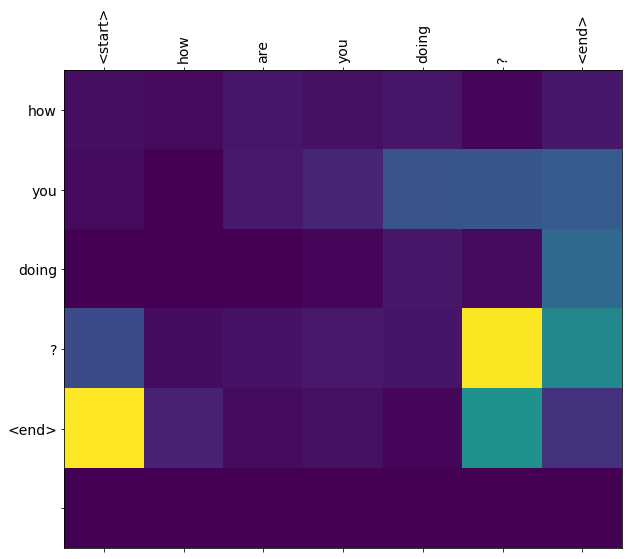

In [49]:
paraphrase('how are you doing ?')

Input: <start> are you ok ? <end>
Predicted paraphrase: you alright ? <end> 


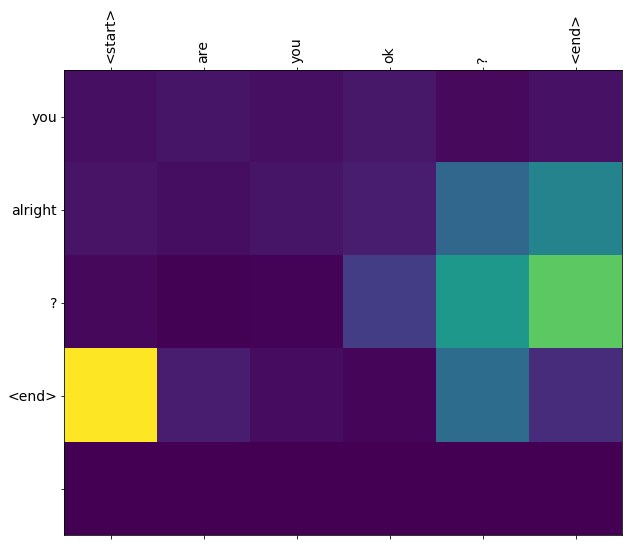

In [51]:
paraphrase('are you ok ?')

Input: <start> how can i help you ? <end>
Predicted paraphrase: what can i do for you ? <end> 


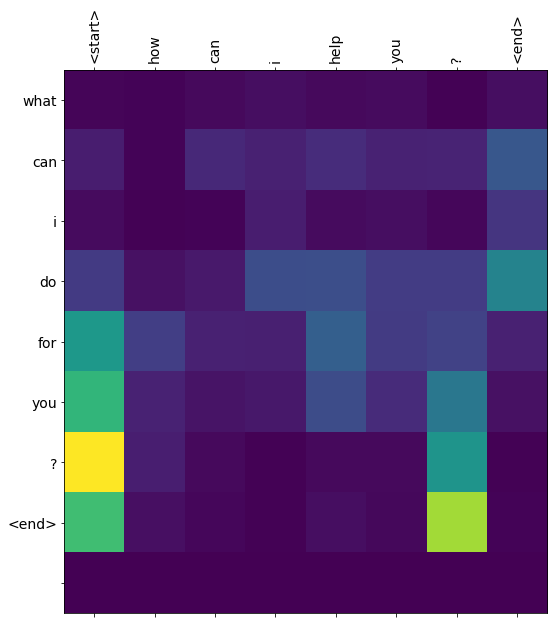

In [52]:
paraphrase('how can i help you ?')